# Prompt to Mask: Combinando Modelos de IA para Segmentación Inteligente

## Configuración e Imports

Importamos las librerías principales, especialmente **Transformers de Hugging Face** que nos permite usar modelos preentrenados de forma sencilla, gratuita y en local.

In [1]:
import torch
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import transformers
import requests
from io import BytesIO
import warnings
from huggingface_hub import snapshot_download
from pathlib import Path
import os, sys
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")



torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


## Descarga de Modelos en Local

**Importante**: Descargamos todos los modelos a nuestro disco local para:
- Evitar descargas repetidas
- Trabajar sin conexión
- Mejor rendimiento

Los modelos que usaremos:
- **GroundingDINO**: Detección de objetos usando texto
- **SAM**: Segmentación precisa 
- **CLIP**: Clasificación imagen-texto
- **BLIP**: Generación de descripciones



Si no se dispone de espacio en disco suficiente se puede obviar esta celda y descargar el modelo en colab cada vez.

In [2]:

if "google.colab" in sys.modules: #Detectamos si estamos en google colab o en local
    from google.colab import drive
    drive.mount('/content/drive')
    HF_MODELS_DIR = Path("/content/drive/MyDrive/hf_models")
else:
    HF_MODELS_DIR = Path(r"G:\Mi unidad\hf_models")

HF_MODELS_DIR.mkdir(parents=True, exist_ok=True)

models = [
    "IDEA-Research/grounding-dino-base",
    "facebook/sam-vit-large",
    "openai/clip-vit-base-patch32",
    "Salesforce/blip-image-captioning-base"
]

for repo in models:
    local_dir = HF_MODELS_DIR / repo
    snapshot_download(
        repo_id=repo,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
        resume_download=True
)

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

## Carga de Modelos Pre-entrenados

Cargamos los modelos desde las rutas locales usando **Transformers**. Nota cómo cada modelo tiene su processor específico que maneja el preprocesamiento de datos.

Si no hemos descargado los modelos usar las rutas comentadas


In [3]:
# models

# utilizar estos para no descargarlos en local
# dino_path = "IDEA-Research/grounding-dino-base"
# sam_path = "facebook/sam-vit-large"
# clip_path = "openai/clip-vit-base-patch32"
# blip_path = "Salesforce/blip-image-captioning-base"

# utilizar estos si están descargados en local
dino_path = HF_MODELS_DIR / "IDEA-Research/grounding-dino-base"
sam_path = HF_MODELS_DIR / "facebook/sam-vit-large"
clip_path = HF_MODELS_DIR / "openai/clip-vit-base-patch32"
blip_path = HF_MODELS_DIR / "Salesforce/blip-image-captioning-base"

dino_processor = AutoProcessor.from_pretrained(dino_path)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_path).to(device)

sam_processor = SamProcessor.from_pretrained(sam_path)
sam_model = SamModel.from_pretrained(sam_path).to(device)

clip_processor = CLIPProcessor.from_pretrained(clip_path)
clip_model = CLIPModel.from_pretrained(clip_path).to(device)

blip_processor = BlipProcessor.from_pretrained(blip_path)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_path, torch_dtype=torch.float16).to(device)

## Carga de Imágenes de Ejemplo

Descargamos imágenes de ejemplo desde el repositorio de GitHub para probar los diferentes modelos, podeis usar imagenes propias con: 
image_custom = Image.open(mi_path_custom).convert("RGB")

In [5]:
# images
url_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cars.jpg"
image_cars = Image.open(BytesIO(requests.get(url_cars).content)).convert("RGB")

url_person_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/person_cars.jpg"
image_person_cars = Image.open(BytesIO(requests.get(url_person_cars).content)).convert("RGB")

url_fruits = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/fruits.jpg"
image_fruits = Image.open(BytesIO(requests.get(url_fruits).content)).convert("RGB")

## CLIP: Clasificación Imagen-Texto

**CLIP** permite comparar una imagen con múltiples descripciones de texto y nos dice cuál es más probable. 

Útil para clasificación sin necesidad de entrenar en categorías específicas - usa **zero-shot learning**.

Model Card: https://huggingface.co/openai/clip-vit-base-patch32

Paper: https://arxiv.org/pdf/2103.00020


'a photo of a street with a person' -> Probability: 0.93
'a photo of a dog' -> Probability: 0.00
'a photo of several cars but without any person on it' -> Probability: 0.07


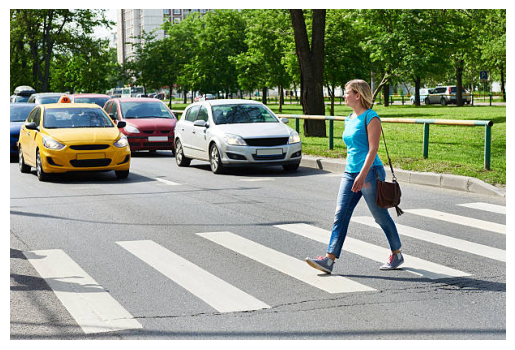

In [5]:
# clip
image = image_person_cars
descriptions = ["a photo of a street with a person", "a photo of a dog", "a photo of several cars but without any person on it"]

inputs = clip_processor(text=descriptions, images=image, return_tensors="pt", padding=True).to(device)

outputs = clip_model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

for desc, prob in zip(descriptions, probs[0].tolist()):
    print(f"'{desc}' -> Probability: {prob:.2f}")
    
plt.imshow(image)
plt.axis("off")
plt.show()

## BLIP: Generación de Descripciones

**BLIP** genera automáticamente descripciones en texto a partir de imágenes.

Proceso inverso a CLIP: en lugar de clasificar, **genera** texto descriptivo.

Model Card: https://huggingface.co/Salesforce/blip-image-captioning-base

Paper: https://arxiv.org/pdf/2201.12086

a woman walking across a crosswalk in a city


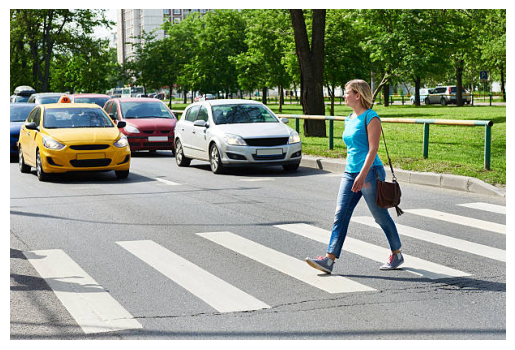

In [6]:
#Blip
image = image_person_cars

inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)

out = blip_model.generate(**inputs)
print(blip_processor.decode(out[0], skip_special_tokens=True))

plt.imshow(image)
plt.axis("off")
plt.show()

## Grounding DINO: Detección Guiada por Texto

**Grounding DINO** encuentra objetos en imágenes usando descripciones en lenguaje natural.

A diferencia de detectores tradicionales que tienen categorías fijas, este modelo puede detectar **cualquier objeto** que describas con palabras.

Devuelve cajas delimitadoras (bounding boxes) con coordenadas y puntuaciones de confianza.

Model Card: https://huggingface.co/IDEA-Research/grounding-dino-base

Paper: https://arxiv.org/pdf/2303.05499

Box: tensor([  9.1007, 114.1031, 150.1337, 211.9612], device='cuda:0'), Label: yellow car, Score: 0.9334998726844788


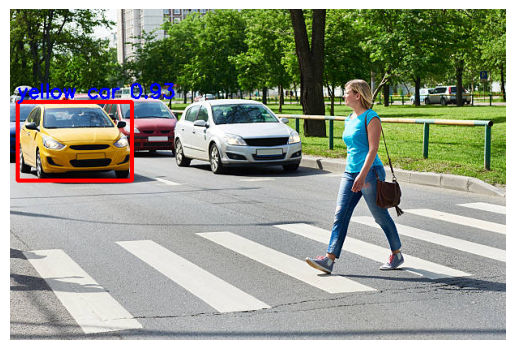

In [7]:
# gounding dino
def detect_objects(image, prompt):
    w, h = image.size
    scale = min(768 / max(h, w), 1.0)
    new_h, new_w = int(h * scale), int(w * scale)

    # Aplicar Grounding DINO - procesamiento directo
    inputs = dino_processor(
        images=image,
        text=prompt,
        return_tensors="pt",
        do_resize=True,
        size={"height": new_h, "width": new_w}
    ).to(device)

    # Ejecutar DINO para detección
    with torch.no_grad():
        outputs = dino_model(**inputs)

    results = dino_processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                threshold=0.7,
                text_threshold=0.7,
                target_sizes=[(h, w)])

    boxes = results[0]['boxes']
    labels = results[0]['labels']
    scores = results[0]['scores']

    # Mostrar resultados
    for box, label, score in zip(boxes, labels, scores):
        print(f"Box: {box}, Label: {label}, Score: {score}")

    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    for box, label, score in zip(boxes, labels, scores):
        x0, y0, x1, y1 = map(int, box)
        cv2.rectangle(img_cv, (x0, y0), (x1, y1), (0,0,255), 3)
        txt = f"{label} {score:.2f}"
        cv2.putText(img_cv, txt, (x0, y0-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    
    return


detect_objects(image_person_cars, ["yellow car"])

# detect_objects(image_fruits, ["kiwi", "orange"])

## SAM: Segmentación Precisa

**SAM (Segment Anything Model)** crea máscaras de segmentación precisas a nivel de píxel.

Toma como entrada una caja delimitadora (del paso anterior) y genera una máscara que delimita exactamente el contorno del objeto.

La máscara resultante es binaria: 1 para píxeles del objeto, 0 para fondo.

Model Card: https://huggingface.co/facebook/sam-vit-large

Paper: https://arxiv.org/pdf/2304.02643

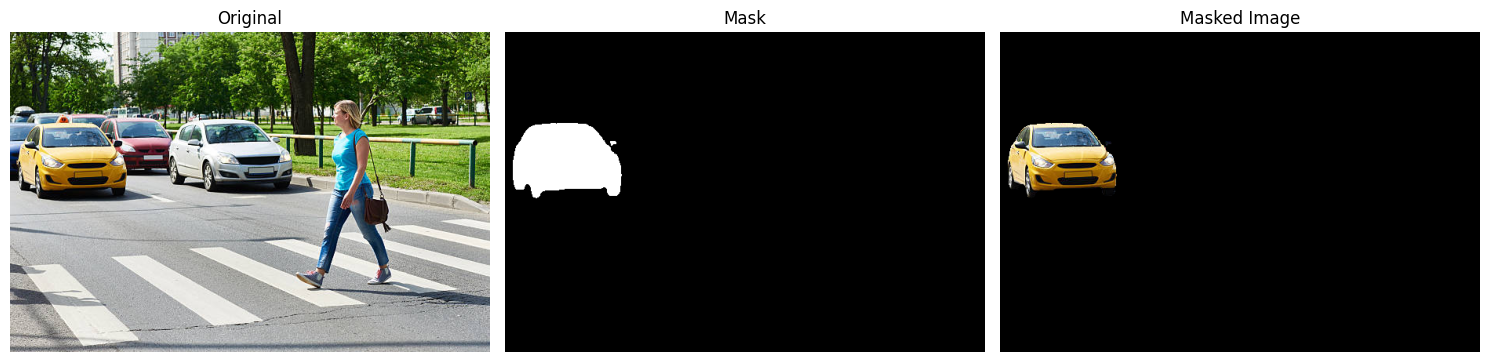

In [8]:
# sam
image = image_person_cars
box = [9.1007, 114.1038, 150.1338, 211.9607]

inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.post_process_masks(outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"])
best_mask = masks[0][0][outputs.iou_scores.argmax()].cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(best_mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
masked_img = np.array(image) * best_mask[:,:,None]
axes[2].imshow(masked_img.astype(np.uint8))
axes[2].set_title("Masked Image")
axes[2].axis("off")
plt.tight_layout()
plt.show()

## Pipeline Completo: Grounding DINO + SAM

Combinamos ambos modelos para crear un sistema de segmentación guiado por texto.

**Proceso**:
1. **DINO** detecta objetos usando texto → obtiene cajas delimitadoras
2. **SAM** refina cada caja → obtiene máscaras precisas  
3. Combinamos todas las máscaras

**Resultado**: Solo con texto natural podemos segmentar cualquier objeto en una imagen.

**Modo Batch**: Procesa múltiples detecciones de una vez para mayor eficiencia.


In [7]:
# dino + sam

def segment_objects(image, prompt, batch_mode=True):
    """Segment objects using DINO + SAM pipeline"""
    w, h = image.size
    scale = min(768 / max(h, w), 1.0)
    new_h, new_w = int(h * scale), int(w * scale)

    inputs = dino_processor(images=image, text=prompt, return_tensors="pt", do_resize=True, size={"height": new_h, "width": new_w}).to(device)

    with torch.no_grad():
        outputs = dino_model(**inputs)

    results = dino_processor.post_process_grounded_object_detection( outputs, inputs.input_ids, threshold=0.3, text_threshold=0.5, target_sizes=[(h, w)])

    boxes = results[0]['boxes'].cpu().numpy().tolist()
    scores = results[0]['scores'].cpu().numpy().tolist()
    labels = results[0]['labels']

    final_mask = np.zeros((h, w), dtype=np.float32)

    if not batch_mode:
        for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
            sam_inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

            with torch.no_grad():
                sam_outputs = sam_model(**sam_inputs)

            masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
            best_mask = masks[0][0][sam_outputs.iou_scores.argmax()].cpu().numpy()
            final_mask += best_mask

    else:
        if len(boxes) > 0:
            sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

            with torch.no_grad():
                sam_outputs = sam_model(**sam_inputs)

            masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
            iou_scores = sam_outputs.iou_scores.cpu().numpy()
            final_mask = np.zeros((h, w), dtype=np.float32)

            for i in range(len(boxes)):
                detection_masks = masks[0][i].cpu().numpy()
                best_idx = iou_scores[0][i].argmax()
                final_mask += detection_masks[best_idx]

    print(f"Prompt: {prompt}")
    final_mask = np.clip(final_mask, 0, 1)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(final_mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")
    masked_img = np.array(image) * final_mask[:,:,None]
    axes[2].imshow(masked_img.astype(np.uint8))
    axes[2].set_title("Masked Image")
    axes[2].axis("off")
    inverted_mask = 1 - final_mask
    removed_img = np.array(image) * inverted_mask[:,:,None]
    axes[3].imshow(removed_img.astype(np.uint8))
    axes[3].set_title("Removed Mask")
    axes[3].axis("off")
    plt.tight_layout()
    plt.show()
    
    return final_mask

segment_objects(image_person_cars, ["cars", "woman"], batch_mode=True)
# segment_objects(image_cars, ["red car"], batch_mode=True)
# segment_objects(image_cars, ["the car that is the same color of lemons"], batch_mode=True)